# Non-Parametric Learners

## kNN and Decision Trees

### John Bourassa
#### December 4, 2017

(much of this content is borrowed from Jack Bennetto's lecture)

## Agenda

#### Morning: kNN

 * Non-parametric models
 * Understanding kNN
 * Scaling
 * Distance metrics
 * Curse of Dimensionality
 
#### Afternoon: Decision Trees
 * Introduction
 * Entropy and purity
 * Recursion
 * Decision-tree algorithm
 * Gini and regression
 * Pre- and post- pruning

In [68]:
from IPython.display import HTML, display

def hidden_answer(f):
    text = f.read().replace("\n", "<br>").replace(" ","&nbsp;")
    html = HTML("""<div onMouseOver="this.style.color='#000'" 
                          onMouseOut="this.style.color='#FFF'"
                          style="color: rgba(0,0,0,0)">"""+text+"</div>")
    display(html)

## Morning Objectives - kNN

* **Implement** pseudocode for kNN algorithm
* **State** common distance metrics used for kNN
* **Describe** effect of varying k (num_neigbors)
* **Explain** importance of scaling for kNN

## Parametric vs. Non-Parametric Models


### Parametric Models

#### Linear Regression


$$\hat y = \hat\beta_0 + \hat\beta_1 X_1 + \hat\beta_2 X_2 + ... + \hat\beta_i X_i $$
    
How many parameters can we describe it with?

Can we ever change the number of parameters?

What does using this model mean about the structure of our data?

## Properties of Parametric Models

In [69]:
# load answers after class discussion
with open('answers/prop_param.txt') as f:
    hidden_answer(f)

#### Examples:
* Linear regression
* Logistic regression

## Properties of Non-Parametric Models

Class discussion: What do you think they are?

In [70]:
# load answers after class discussion
with open('answers/prop_non_param.txt') as f:
    hidden_answer(f)

Class discussion: contrast the pros and cons of these two types of models

## Pros-Cons of Parametric Models

In [71]:
# load answers after class discussion
with open('answers/pc_param.txt') as f:
    hidden_answer(f)

## Pros-Cons of Non-parametric Models

In [72]:
# load answers after class discussion
with open('answers/pc_nonparam.txt') as f:
    hidden_answer(f)

In [73]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as scs
import operator
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets, tree
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

%matplotlib inline
# Make it pretty
plt.style.use('ggplot')

# Seed random functions for reproducibility
#np.random.seed(12345)

In [74]:
#Load in iris dataset
iris = datasets.load_iris()
X = iris["data"]
y = iris["target"]

#Reduce the data down to 2 classes and 2 predictor variables
X = X[y != 0, :2] 

#Add some noise so data points aren't exactly duplicated
X = X + np.random.normal(0, .05, size = X.shape)

#Change Sepal Length from cm to mm to cause scaling issues
X[:,0] = X[:,0] * 10
y = y[y != 0] - 1

In [75]:
#Save some points for later
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = .1)

In [76]:
def plot_flower_data(ax, X, y):
    ax.scatter(X[y == 0,0], X[y == 0,1], c = "orange", label = "versicolor")
    ax.scatter(X[y == 1, 0], X[y == 1, 1], color = "black", label = "virginica")
    ax.legend()

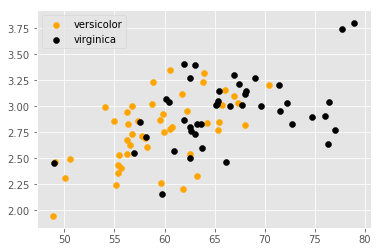

In [77]:
fig, ax = plt.subplots()
plot_flower_data(ax, Xtrain, ytrain)

## What if we get new data? 

In [78]:
Xtest

array([[ 59.28232028,   2.93859987],
       [ 71.72362037,   3.59242365],
       [ 66.45696941,   3.12877488],
       [ 63.90192808,   3.25425141],
       [ 58.40687997,   2.66187749],
       [ 52.3857966 ,   2.62900962],
       [ 64.4056055 ,   2.99868765],
       [ 68.5833435 ,   3.08820952],
       [ 56.00795253,   3.03125033],
       [ 56.59184119,   2.87447064]])

## What type of flower are they?

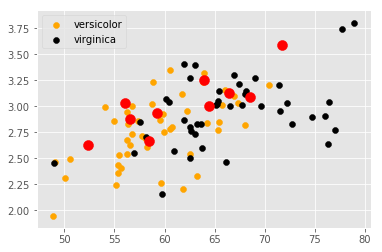

In [79]:
# Plot the new points

fig, ax = plt.subplots()

# Plot the original data
plot_flower_data(ax, Xtrain, ytrain)

ax.scatter(Xtest[:,0], Xtest[:,1], color = "red", s = 100)

## kNN pseudocode

Class discussion: What do you think this is? Describe both the training and prediction phases.

In [80]:
# load answers after class discussion
with open('answers/knn_pseudocode.txt') as f:
    hidden_answer(f)

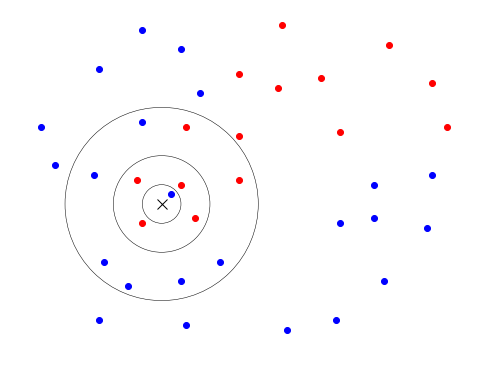

In [81]:
fig, ax = plt.subplots(figsize=(8,8))

a = np.array([[2.1, 3.2, 2.0, 2.9, 4.1, 3.0, 4.1, 6.2, 8.4, 4.1, 4.9, 5.8, 8.1, 5.0, 7.2],
              [3.1, 3.2, 4.0, 3.9, 4.0, 5.1, 4.9, 5.0, 5.1, 6.2, 5.9, 6.1, 6.0, 7.2, 6.8]])
b = np.array([[1.2, 1.8, 3.0, 5.1, 6.1, 1.3, 2.9, 3.7, 7.1, 6.2, 6.9, 8.0, 2.7, 0.3, 1.1, 6.9, 8.1, 0.0, 2.1, 1.2, 3.3, 2.1, 2.9],
              [1.1, 1.8, 1.0, 0.9, 1.1, 2.3, 1.9, 2.3, 1.9, 3.1, 3.2, 3.0, 3.7, 4.3, 4.1, 3.9, 4.1, 5.1, 5.2, 6.3, 5.8, 7.1, 6.7]])
center = np.array([[2.5], [3.5]])
ax.plot(a[0], a[1], 'ro')
ax.plot(b[0], b[1], 'bo')
ax.plot(center[0], center[1], 'kx', ms=10) 
ax.add_artist(plt.Circle(center, 0.4, fc='None', ec='k', lw=0.5))
ax.add_artist(plt.Circle(center, 1.0, fc='None', ec='k', lw=0.5))
ax.add_artist(plt.Circle(center, 2.0, fc='None', ec='k', lw=0.5))
ax.set_aspect('equal')
plt.axis('off')
plt.show()

What do we predict for different values of k?

In [82]:
def plot_mult_decision_boundary(ax, X, y, k, scaled=True, 
                                title='Title', xlabel='xlabel', 
                                ylabel='ylabel', hard_class = True):
    
    """Plot the decision boundary of a kNN classifier.
    
    Builds and fits a sklearn kNN classifier internally.

    X must contain only 2 continuous features.

    Function modeled on sci-kit learn example.

    Parameters
    ----------
    ax: Matplotlib axes object
        The plot to draw the data and boundary on
        
    X: numpy array
        Training data
    
    y: numpy array
        Target labels
    
    k: int
        The number of neighbors that get a vote.
        
    scaled: boolean, optional (default=True)
        If true scales the features, else uses features in original units
    
    title: string, optional (default = 'Title')
        A string for the title of the plot
    
    xlabel: string, optional (default = 'xlabel')
        A string for the label on the x-axis of the plot
    
    ylabel: string, optional (default = 'ylabel')
        A string for the label on the y-axis of the plot
    
    hard_class: boolean, optional (default = True)
        Use hard (deterministic) boundaries vs. soft (probabilistic) boundaries
    

    Returns
    -------
    None
    """
    x_mesh_step_size = 0.1
    y_mesh_step_size = 0.01
    
    #Hard code in colors for classes, one class in red, one in blue
    bg_colors = np.array([np.array([255, 150, 150])/255, np.array([150, 150, 255])/255])
    cmap_light = ListedColormap(bg_colors)
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    
    #Build a kNN classifier
    clf = neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')
    
    if scaled:
        #Build pipeline to scale features
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X, y)
    else:
        clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = 45, 85
    y_min, y_max = 2, 4
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, x_mesh_step_size),
                         np.arange(y_min, y_max, y_mesh_step_size))
    if hard_class:
        dec_boundary = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        ax.pcolormesh(xx, yy, dec_boundary, cmap=cmap_light)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    else:
        dec_boundary = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        colors = dec_boundary.dot(bg_colors)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
        ax.imshow(colors.reshape(200, 400, 3), origin = "lower", aspect = "auto", extent = (x_min, x_max, y_min, y_max))

    ax.set_title(title + ", k={0}, scaled={1}".format(k, scaled))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))

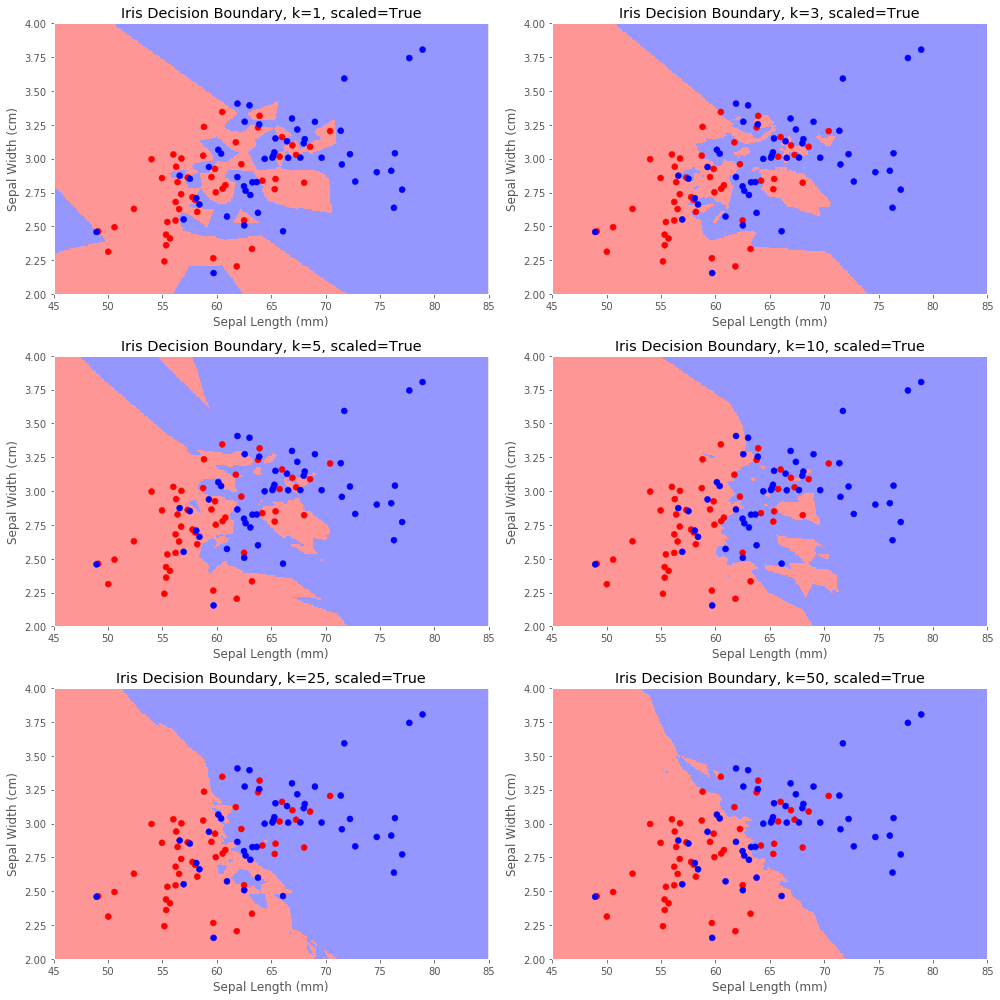

In [83]:
some_ks = [1, 3, 5, 10, 25, 50]

title="Iris Decision Boundary"
xlabel="Sepal Length (mm)"
ylabel="Sepal Width (cm)"

# Building my plot, 3 rows x 2 columns
fig, axs = plt.subplots(3, 2, figsize=(14, 14))
 
# Loop through the possible ks, put each decision boundary a separate axes
for k, ax in zip(some_ks, axs.flatten()):
    plot_mult_decision_boundary(ax, X, y, k=k, title = title, xlabel = xlabel, ylabel = ylabel)

# Keep things from overlapping
plt.tight_layout()
plt.show()

In [84]:
def predict_sample(k):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
    
    clf = make_pipeline(StandardScaler(), neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform'))
    clf.fit(X_train, y_train)
    
    return clf.score(X_test, y_test)

### k start

How do we figure out the best value for k?

In general, a good starting point for k is $\sqrt{n}$

Let's investigate for various values.

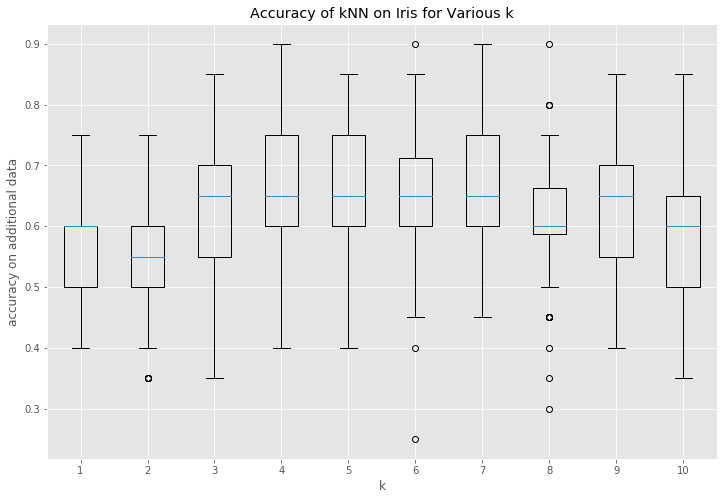

In [85]:
max_k = 11
step = 1
results = []
for k in range(1, max_k, step):
    kresults = []
    for _ in range(100):
        kresults.append(predict_sample(k))
    results.append(kresults)
results = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(12, 8))

data = np.array(results.T)
ax.boxplot(data, labels=range(1, max_k, step))
ax.set_xlabel("k")
ax.set_ylabel("accuracy on additional data")
ax.set_title("Accuracy of kNN on Iris for Various k")
plt.show()

## Bias-Variance

What is bias and variance again?

Class discussion: How does changing k affect each? Why?

### Bias

In [86]:
# load answers after class discussion
with open('answers/bias_knn.txt') as f:
    hidden_answer(f)

### Variance

In [87]:
# load answers after class discussion
with open('answers/variance_knn.txt') as f:
    hidden_answer(f)

In [88]:
# Create samples from a multivariate normal distribution
# which approximates the input data
def gen_similar_samples(X, y, n_samples = 4, sample_size = 50):
    Xs = []
    ys = []
    for _ in range(n_samples):
        Xdata = np.zeros_like(X)
        ydata = np.zeros_like(y)
        for i, value in enumerate(np.unique(y)):
            Xdata[i*sample_size:(i+1)*sample_size] = np.random.multivariate_normal(X[y == value].mean(axis = 0), 
                                                                                   np.cov(X[y == value].T), 
                                                                                   sample_size)
            ydata[i*sample_size:(i+1)*sample_size] = value
        Xs.append(Xdata)
        ys.append(ydata)
    
    return list(zip(Xs, ys))

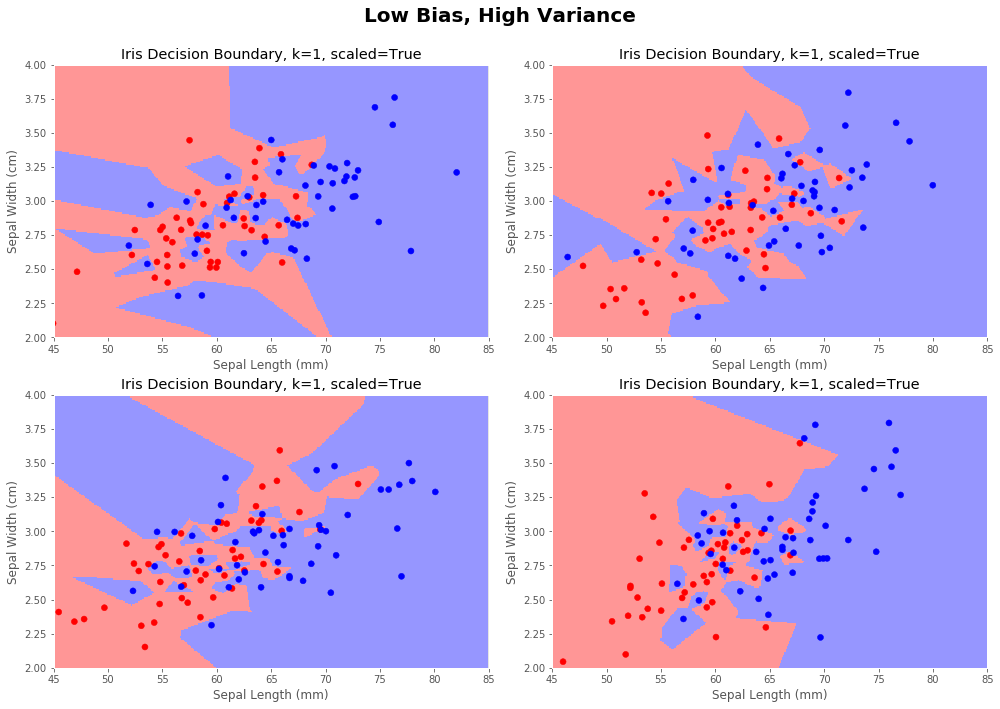

In [89]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
test_data = gen_similar_samples(X, y)
for sample, ax in zip(test_data, axs.flatten()):
    X_sample = sample[0]
    y_sample = sample[1]
    plot_mult_decision_boundary(ax, X_sample, y_sample, k=1, title=title, xlabel=xlabel, ylabel=ylabel)

plt.tight_layout()
# Offset the figure title to make it look nice
plt.subplots_adjust(top=0.9)
# Set a title for the entire figure
plt.suptitle('Low Bias, High Variance', fontsize=20, weight='bold')
plt.show()

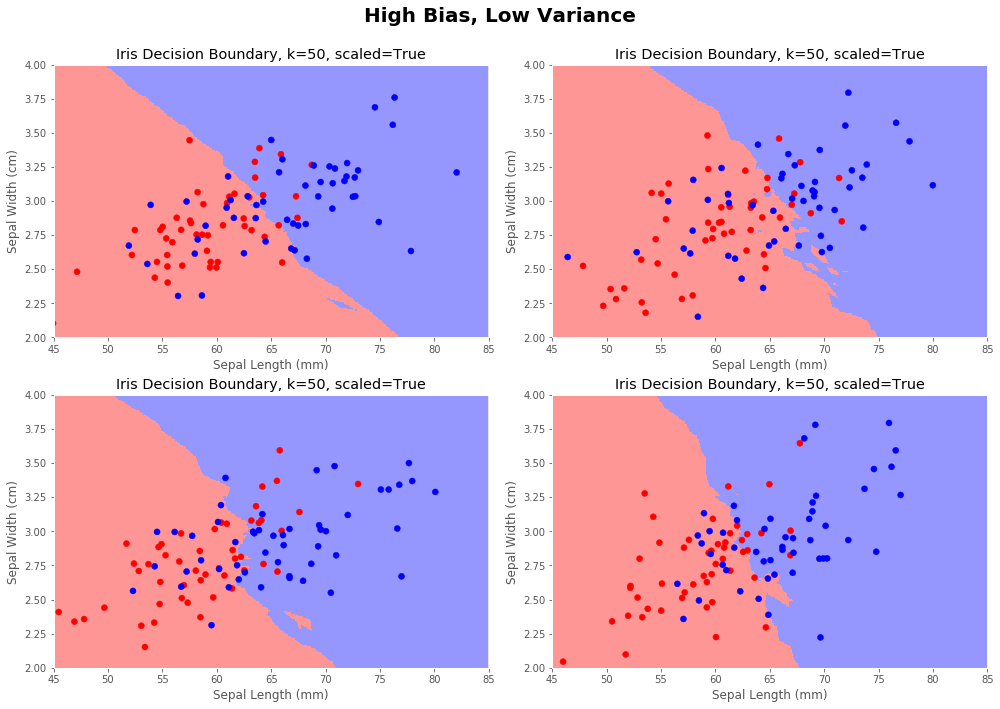

In [90]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for sample, ax in zip(test_data, axs.flatten()):
    X = sample[0]
    y = sample[1]
    plot_mult_decision_boundary(ax, X, y, k=50, title=title, xlabel=xlabel, ylabel=ylabel)
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('High Bias, Low Variance', fontsize=20, weight='bold')
plt.show()

## Scaling Could Be Important

What is going on in these plots?

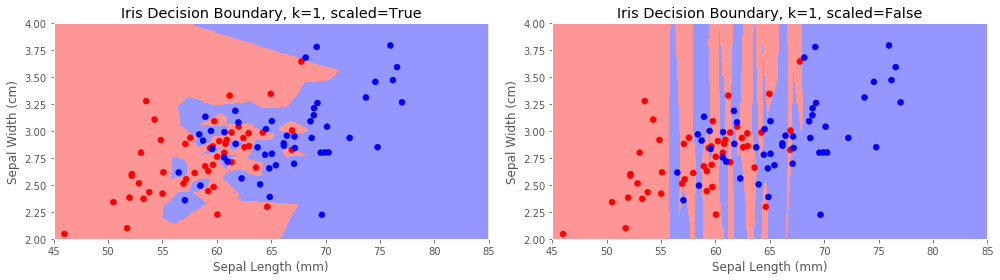

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
                        
plot_mult_decision_boundary(axs[0], X, y, k=1, title=title, xlabel=xlabel, ylabel=ylabel)
plot_mult_decision_boundary(axs[1], X, y, k=1, scaled=False, title=title, xlabel=xlabel, ylabel=ylabel)

plt.tight_layout()
plt.show()

Scaling important for any algorithms that use distance.  If changing the units will change the predictions, scale the data first.

## Distance Metrics

A few common distance metrics, but there are many more.

### Manhattan Distance
City blocks, L1

*Manhattan* distance is the distance as measured along axes at right angles:

$$\sum_i |a_i - b_i|$$


### Euclidean Distance

Straight line, L2

*Euclidean* distance is the distance metric you're most familiar with:

$$ d(\mathbf{a}, \mathbf{b}) = ||\mathbf{a} - \mathbf{b}|| \ = \sqrt{\sum (a_i - b_i)^2} $$

### Cosine Similarity

Angle

*Cosine* similarity is another commonly used distance metric. It's measuring the angle between the two vectors:

$$ d(\mathbf{a}, \mathbf{b}) = \frac{\mathbf{a} \cdot \mathbf{b}}{||\mathbf{a}||  ||\mathbf{b}||} $$


#### sklearn default is Minkowski (with p=2 which is really just euclidean, p=1 is manhattan)

##### Test your understanding:

Which of these people are the most similar?  Which would be the most similar by Euclidean or Manhattan distance?

| age | salary |
|--|--|
| 25 | 60k |
| 25 | 62k |
| 75 | 60k |

## Curse of Dimensionality

### Perspective 1: Sample Density

Sampling density is proportional to $$N^\frac{1}{p}$$

where N is the number of samples and p is the number of dimensions.

Let's consider a data set with 100 samples that all have only one feature/predictor. But, you feel that one feature doesn't tell you enough to properly predict anything, so you set out to collect new data. The new data will have ten features/predictors for each sample. How many samples do we need to have an equally dense sample as our original dataset?

#### Original Sample

$$\begin{align}
          density & = N^\frac{1}{p} \\
          & = 100^\frac{1}{1} \\
          & = 100 
\end{align}$$

#### New Sample

$$\begin{align}
          N & = density^ p \\
          &= 100^{10} \\
          &= 100,000,000,000,000,000,000
\end{align}$$

No big, just one hundred quadrillion samples...

### Perspective 2: Loss of Locality

As we increase dimensionality, we lose the concept of locality and things get infinitely far apart.

More precisely, samples that are simliar no longer look similar and "closeness" becomes more arbitrary than meaningful. 

For example, in Euclidean distance we must be close in ***all*** dimensions to be considered close.

Close in 2 of 3 dimensions, but far in the 3rd dimension makes the points far apart.



1 dim: 67.52%
2 dim: 39.16%
3 dim: 19.80%
4 dim: 9.23%
5 dim: 3.97%
6 dim: 1.45%
7 dim: 0.54%
8 dim: 0.22%
9 dim: 0.08%
10 dim: 0.03%


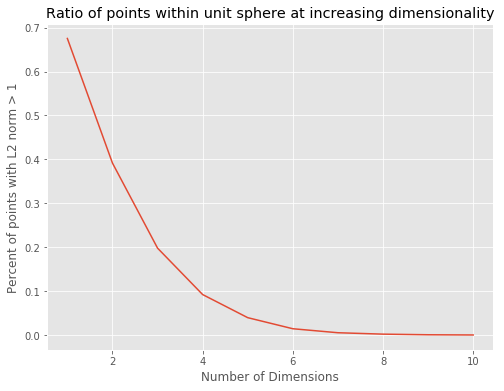

In [92]:
# Points drawn from a standard normal distribution 
# get further from the origin as dimensionality increases
n_points = 10000

norm_data = np.random.normal(size = (n_points, 10))
pct_close = []
for i in range(1, 11):
    value = np.mean(np.linalg.norm(norm_data[:,:i], axis = 1) < 1)
    print("{} dim: {:.2f}%".format(i, value * 100))
    pct_close.append(value)

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(range(1, 11), pct_close)
ax.set_ylabel("Percent of points with L2 norm > 1")
ax.set_xlabel("Number of Dimensions")
ax.set_title("Ratio of points within unit sphere at increasing dimensionality");

## Pros and Cons of kNN

Class discussion: what do you think they are? why?

In [93]:
# load answers after class discussion
with open('answers/pc_knn.txt') as f:
    hidden_answer(f)

## kNN Variants

Here are a few common variants on the kNN algorithm.

### Weighted Voting

<img src="images/weighted_knn.png" width=500 align="left"/>

Let the k nearest points have distances $$d_1, d_2,..., d_k$$

The ith point votes with weight of $$\frac{1}{d_i}$$

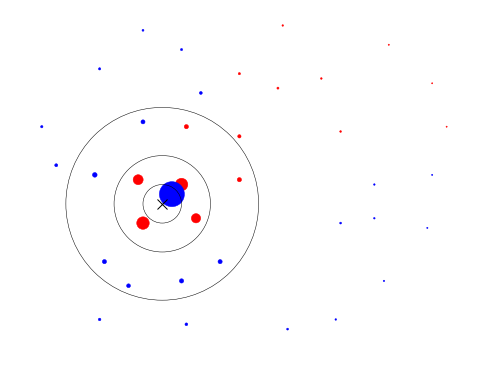

In [94]:
fig, ax = plt.subplots(figsize=(8,8))

a = np.array([[2.1, 3.2, 2.0, 2.9, 4.1, 3.0, 4.1, 6.2, 8.4, 4.1, 4.9, 5.8, 8.1, 5.0, 7.2],
              [3.1, 3.2, 4.0, 3.9, 4.0, 5.1, 4.9, 5.0, 5.1, 6.2, 5.9, 6.1, 6.0, 7.2, 6.8]])
b = np.array([[1.2, 1.8, 3.0, 5.1, 6.1, 1.3, 2.9, 3.7, 7.1, 6.2, 6.9, 8.0, 2.7, 0.3, 1.1, 6.9, 8.1, 0.0, 2.1, 1.2, 3.3, 2.1, 2.9],
              [1.1, 1.8, 1.0, 0.9, 1.1, 2.3, 1.9, 2.3, 1.9, 3.1, 3.2, 3.0, 3.7, 4.3, 4.1, 3.9, 4.1, 5.1, 5.2, 6.3, 5.8, 7.1, 6.7]])
center = np.array([[2.5], [3.5]])
asize = 50/((a - center)**2).sum(axis=0)
bsize = 50/((b - center)**2).sum(axis=0)
ax.scatter(a[0], a[1], c='r', s=asize)
ax.scatter(b[0], b[1], c='b', s=bsize)
ax.plot(center[0], center[1], 'kx', ms=10) 
ax.add_artist(plt.Circle(center, 0.4, fc='None', ec='k', lw=0.5))
ax.add_artist(plt.Circle(center, 1.0, fc='None', ec='k', lw=0.5))
ax.add_artist(plt.Circle(center, 2.0, fc='None', ec='k', lw=0.5))
ax.set_aspect('equal')
plt.axis('off')
plt.show()

### Regression kNN

<img src="images/regression_knn.png" width=500 align="left"/>

Let the k nearest points have distances $$d_1, d_2,..., d_k$$

Let the k nearest points have targets $$t_1, t_2,..., t_k$$

Predict the mean value ***or*** predict a weighted average

### Soft KNN

No longer "tyranny of the majority."  Each point has class probabilities instead of a hard label.  Just use predict_proba instead of predict!

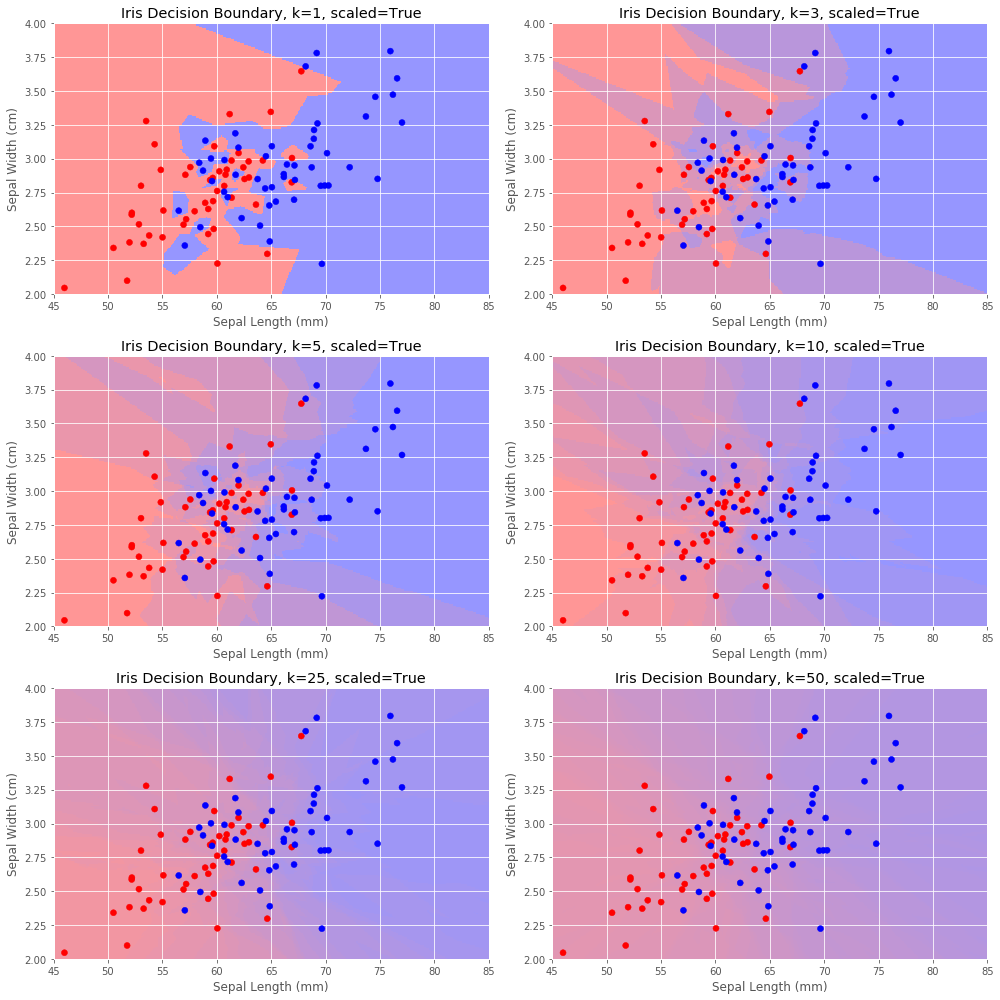

In [95]:
# Building my plot, 3 rows x 2 columns
fig, axs = plt.subplots(3, 2, figsize=(14, 14))
#ax.imshow()
# Loop through the possible ks, put each decision boundary a separate axes
for k, ax in zip(some_ks, axs.flatten()):
    plot_mult_decision_boundary(ax, X, y, k=k, title = title, xlabel = xlabel, ylabel = ylabel, hard_class = False)

# Keep things from overlapping
plt.tight_layout()
plt.show()

# Afternoon Lecture

## Objectives  - Decision trees

* **Describe** pros/cons of decision tree algorithm
* **Implement** pseudocode for decision tree algorithm
* **Describe** common measures for making splits in a decision tree
* **Demonstrate** concept of recursion and **relate** it to decision trees
* **State** pruning techniques

In [96]:
# Read in our data
tennis_df = pd.read_table('data/tennis.txt', delim_whitespace=True)

In [97]:
# Clean up a few things, based on my preferences and making calculating probabilities easier
tennis_df.rename(columns={'playtennis': 'played'}, inplace=True)
tennis_df['played'] = tennis_df['played'].apply(lambda x: 1 if x == 'yes' else 0)

In [98]:
# Let's look at the data
tennis_df.sort_values('played')

,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,0
1,sunny,hot,high,True,0
5,rainy,cool,normal,True,0
7,sunny,mild,high,False,0
13,rainy,mild,high,True,0
2,overcast,hot,high,False,1
3,rainy,mild,high,False,1
4,rainy,cool,normal,False,1
6,overcast,cool,normal,True,1
8,sunny,cool,normal,False,1


## How Would You Determine If You Played Tennis?

Class discussion

## Quantifying Our Decisions

### Shannon Entropy

Common measure of impurity.  Shannon Entropy quantifies the amount of information gained by observing a random variable.  The value of receiving this new information is inversely proportional to the probability of it occurring.  For example, if you are told that you are going to be doing pair exercises this afternoon, that doesn't provide you any additional information.

While the occurrence of very uncommon events does provide you the most information, they are also very unlikely.  Since Shannon Entropy calculates the expectation of the information provided by observing a random process, maximal entropy is achieved when all outcomes are equally likely.

$$\begin{align}
H(X) & = E[I(X)] \\
     & = E[log_2(\tfrac{1}{Pr(X)})] \\
     & = -E[log_2(Pr(X))] \\
     & = - \sum_i Pr_i log_2(Pr_i)
\end{align}
$$

X = Discrete Random Variable

I(X) = Information Content of X

Pr$_i$ = Probability of X taking on value i

log$_2$(Pr$_i$) = "Information" supplied by observing value i

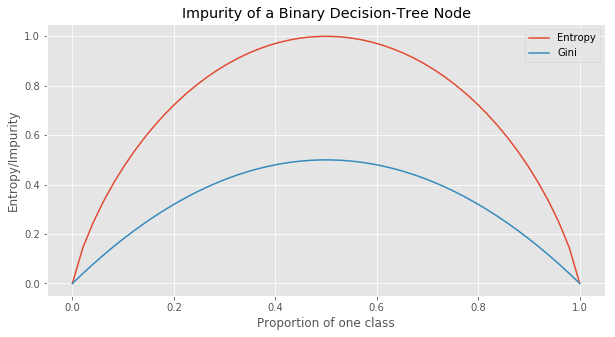

In [99]:
def xlog2x(x):
    '''return x * log2(x), returning 0 for x==0'''
    return scipy.special.xlogy(x,x) / np.log(2)

x = np.linspace(0, 1)
entropy = - (xlog2x(x) + xlog2x(1-x))
gini = (1 - x**2 - (1-x)**2)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, entropy, label="Entropy")
ax.plot(x, gini, label="Gini")
ax.set_ylabel("Entropy/Impurity")
ax.set_xlabel("Proportion of one class")
ax.set_title("Impurity of a Binary Decision-Tree Node")
ax.legend()

### Gini Index

Probability of a mis-classification occurring if random samples from the distribution are classified according to the probability of the distribution.

For example, say X represents the beverage your coworker drinks in the morning, and after watching them for a few weeks (_creepy_) you estimate the following:

P(x = "coffee") = .2

P(x = "tea") = .5

P(x = "water") = .3

If each morning you generated a random number and used that to predict your coworker's beverage choice of the day, how often would you be correct?

P(x = "coffee", guess = "coffee") = P(x = "coffee") * P(guess = "coffee")

P(x = "coffee") == P(guess = "coffee") == .2

P(x == guess) = .2$^2$ + .5$^2$ + .3$^2$ = .38

And the Gini Index is just 1 minus the probability of a correct guess!

$$\text{Gini}(S) = 1 - \sum_{i \in S} Pr_i^2$$

In [100]:
def calc_entropy(y):
    """Return the entropy of the array y.
    
    Parameters
    ----------
    y: 1d numpy array
    
    Returns
    -------
    float
    """
    total_samples = y.shape[0]
    summation = 0
    
    for class_i in np.unique(y):
        prob = sum(y == class_i) / float(total_samples)
        summation += prob * np.log2(prob)
    
    return -summation

In [101]:
y_tennis = tennis_df['played'].values

print("Entropy of original data set is {}".format(calc_entropy(y_tennis)))

Entropy of original data set is 0.9402859586706311


### Information Gain for Entropy

$$\text{IG}(S, C) = H(S) - \sum_{C_i \in C} \frac{|C_i|}{|S|} H(C_i)$$


C = Candidate subsets of S

|C|, |S| = Number of elements in C, S

In [102]:
def calc_info_gain(y, y1, y2, impurity_func):
    """Return the information gain of making the given split.
    
    Parameters
    ----------
    y: 1d numpy array
        Labels for parent node
    
    y1: 1d numpy array
        Labels for potential child node 1
    
    y2: 1d numpy array
        Labels for potential child node 2
    
    impurity_func: function
        Function which calculates the impurity of the node 
        (e.g. Shannon Entropy)
    
    Returns
    -------
    float
    """
    total_samples = float(y.shape[0])
    child_imp = 0
    y_impurity = impurity_func(y)
    
    for child_node in (y1, y2):
        child_num = child_node.shape[0]
        child_imp += (child_num / total_samples) * impurity_func(child_node)
        
    return y_impurity - child_imp

In [103]:
# Let's split on the temperature.

y1 = tennis_df[tennis_df['temperature'] == 'hot']['played'].values
y2 = tennis_df[tennis_df['temperature'] != 'hot']['played'].values

In [104]:
print("Information Gain is {0}.".format(calc_info_gain(y_tennis, y1, y2, calc_entropy)))

Information Gain is 0.02507817350585062.


In [105]:
# Not much gain, maybe I really liked playing when the temperature was mild
# Let's try that split

y1 = tennis_df[tennis_df['temperature'] == 'mild']['played'].values
y2 = tennis_df[tennis_df['temperature'] != 'mild']['played'].values

In [106]:
print("Information Gain is {0}.".format(calc_info_gain(y_tennis, y1, y2, calc_entropy)))

Information Gain is 0.0013397424044413464.


In [107]:
# Still not much headway, let's just try every possible split and see what works
# And also confirm what we used our common sense algorithm we started with

possible_splits = {}
# Get just my features from the dataframe
feature_cols = tennis_df.drop('played', axis=1).columns

# For a given column, find all the unique possible values
for col in feature_cols:
    col_splits = np.unique(tennis_df[col])
    # For each possible value, split the dataset using that value
    for pos_val in col_splits:
        y1 = tennis_df[tennis_df[col] == pos_val]['played'].values
        y2 = tennis_df[tennis_df[col] != pos_val]['played'].values
        # Calculate the information gain, save it for later
        ig = calc_info_gain(y_tennis, y1, y2, calc_entropy)
        key = "{0}: {1}".format(col, pos_val)
        possible_splits[key] = ig

In [108]:
# Print out our results in a pretty way
colname1 = "Col Name: Value"
colname2 = "Information Gain"

# :20 is specifying a column width, https://docs.python.org/3/library/string.html#formatspec
print("{0:20} || {1}".format(colname1, colname2))
print("-"*40)
# operator.itemgetter(1) allows us to sort by the second item of the tuple
for k,v in sorted(possible_splits.items(), key=operator.itemgetter(1), reverse=True):
    print("{0:20} || {1}".format(k, round(v, 4)))
    

Col Name: Value      || Information Gain
----------------------------------------
outlook: overcast    || 0.226
humidity: high       || 0.1518
humidity: normal     || 0.1518
outlook: sunny       || 0.1022
wind: False          || 0.0481
wind: True           || 0.0481
temperature: hot     || 0.0251
temperature: cool    || 0.015
outlook: rainy       || 0.0032
temperature: mild    || 0.0013


In [109]:
# Splitting on overcast gave us the largest info gain
# Let's look at what those child nodes look like and their respective entropies
child_node_left = tennis_df[tennis_df['outlook'] == 'overcast']
print("Entropy of left child node is {0}".format(
          calc_entropy(child_node_left['played'].values)))
child_node_left

Entropy of left child node is -0.0


,outlook,temperature,humidity,wind,played
2,overcast,hot,high,False,1
6,overcast,cool,normal,True,1
11,overcast,mild,high,True,1
12,overcast,hot,normal,False,1


In [110]:
# Ok, we got a pure node, that makes sense.
# What about the other node?
child_node_right = tennis_df[tennis_df['outlook'] != 'overcast']
print("Entropy of right child node is {0}".format(
          calc_entropy(child_node_right['played'].values)))
child_node_right

Entropy of right child node is 1.0


,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,0
1,sunny,hot,high,True,0
3,rainy,mild,high,False,1
4,rainy,cool,normal,False,1
5,rainy,cool,normal,True,0
7,sunny,mild,high,False,0
8,sunny,cool,normal,False,1
9,rainy,mild,normal,False,1
10,sunny,mild,normal,True,1
13,rainy,mild,high,True,0


Class discussion: why in the world would we want a node that has maximum entropy?

## How would you know how to stop?

Class discussion: When would you stop? Potential problems?

Will get to this soon.

In [111]:
# load answers after class discussion
with open('answers/regtree.txt') as f:
    hidden_answer(f)

## Regression Trees

### Splitting Continuous Values

Class discussion: how would you do it?

## Predicting

The final predictions of a decision tree and a regression tree are implemented differently:

### Classification

* Majority class in leaf node
* Better to predict probability of label (impure leaf nodes)

### Regression

* Mean of values in leaf node
* Linear Regression (ooo, fancy)
    * Also called *model trees*

## Recursion

Recursion uses the idea of "divide and conquer" to solve problems. It divides a complex problem you are working on into smaller sub-problems that are easily solved, rather than trying to solve the complex problem directly.

Recursive functions split the problem into two cases: the ***base case*** and the ***recursive case***. The function continually loops, calling itself, until it reaches the base case.

* Base case: Stopping criteria, the simplest case that can be solved directly.
* Recursive case: Function that splits the problem into the smaller subproblems.
    
### Three Laws of Recursion

1. A recursive algorithm must have a base case.
2. A recursive algorithm must change its state and move toward the base case.
3. A recursive algorithm must call itself, recursively.
    
### Example: Factorial

Are the following functions the same?

$$ f(x) = \prod_{i=1}^xi $$

$$f(x) =
\left\{
	\begin{array}{ll}
		1  & \mbox{if } x \leq 1 \\
		xf(x-1) & \mbox otherwise
	\end{array}
\right.
$$

In [112]:
def factorial(x):
    """Recursively calculate x!"""
    # base case is when we get to x=0, which is 0! = 1
    if x <= 1:
        return 1
    # otherwise, recursive case, notice how we are reducing x
    else:
        return x * factorial(x-1)

In [113]:
factorial(4)

24

***Map out on whiteboard***

In [114]:
factorial(25)

15511210043330985984000000

In [115]:
def power(base, exp):
    """Recursively caclulate base ** exp"""
    # base case is when exp = 0, base ** 0 = 1
    if exp <= 0:
        return 1
    #  otherwise, recursive case, reduce exp
    return base * power(base, exp - 1)

In [116]:
power(3, 4)

81

***Map out on whiteboard***

In [117]:
%%timeit -n 20
power(25, 5)

2.29 µs ± 844 ns per loop (mean ± std. dev. of 7 runs, 20 loops each)


In [118]:
%%timeit -n 20
25 ** 5

16.9 ns ± 12.6 ns per loop (mean ± std. dev. of 7 runs, 20 loops each)


Recursion not always the answer, but useful tool to have.

### You do, fill in the following function

In [119]:
def len_str(s):
    """Recursively determine the length of a string"""
    # base case, when should you stop?  
    # recursive case, how can you reduce your problem?
    pass

In [120]:
#test your function

## DT Pseudocode

Recursive partitioning algorithm

```
function BuildTree:
    # base case, stop building tree
    If every item in the dataset is in the same class
    or there is not feature left to split the data:
        return a leaf node with the class label
    # recursive case, keep splitting stuff
    Else:
        find the best feature and value to split the data
        split the dataset
        create a node
        for each split
            call Build Tree and add the result as a child of the node
        return node
```

## Performance of Decision Trees

Class discussion: what are some problems you forsee with this approach?

In [121]:
def plot_classification_tree(ax, X, y, model=None, fit = True):
    ax.plot(X[y==0, 0], X[y==0, 1], 'r.', label='versicolor')
    ax.plot(X[y==1, 0], X[y==1, 1], 'b.', label='virginica')
    ax.set_title("Classifying Iris with Decision Trees")
    ax.set_xlabel("Sepal Length (mm)")
    ax.set_ylabel("Sepal Width (cm)")
    ax.legend(loc='upper left')
    
    if model is None:
        model = tree.DecisionTreeClassifier()
    if fit:
        model.fit(X, y)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plot_classification_thresholds(ax, X, y, 0, model.tree_, xlim, ylim)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

def plot_classification_thresholds(ax, X, y, inode, tree, xlim, ylim):
    threshold = tree.threshold[inode]
    if tree.feature[inode] == -2:
        color = ['r', 'b'][np.argmax(tree.value[inode])]
        ax.add_patch(Rectangle((xlim[0], ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0], fc=color, alpha=0.3))
        return
    if tree.feature[inode] == 0:
        ax.plot((threshold, threshold), ylim, 'k', lw=0.5)
        plot_classification_thresholds(ax, X, y, tree.children_left[inode],  tree, (xlim[0], threshold), ylim)
        plot_classification_thresholds(ax, X, y, tree.children_right[inode], tree, (threshold, xlim[1]), ylim)
    else:
        ax.plot(xlim, (threshold, threshold), 'k', lw=0.5)
        plot_classification_thresholds(ax, X, y, tree.children_left[inode],  tree, xlim, (ylim[0], threshold))
        plot_classification_thresholds(ax, X, y, tree.children_right[inode], tree, xlim, (threshold, ylim[1]))        


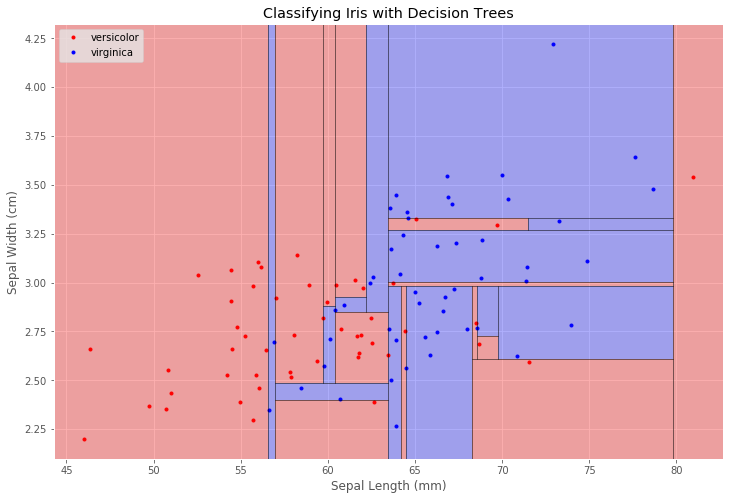

In [122]:
X, y = gen_similar_samples(X, y, 1)[0]
model = tree.DecisionTreeClassifier()
fig, ax = plt.subplots(figsize=(12,8))
plot_classification_tree(ax, X, y, model)

Clearly there is some risk of overfitting.

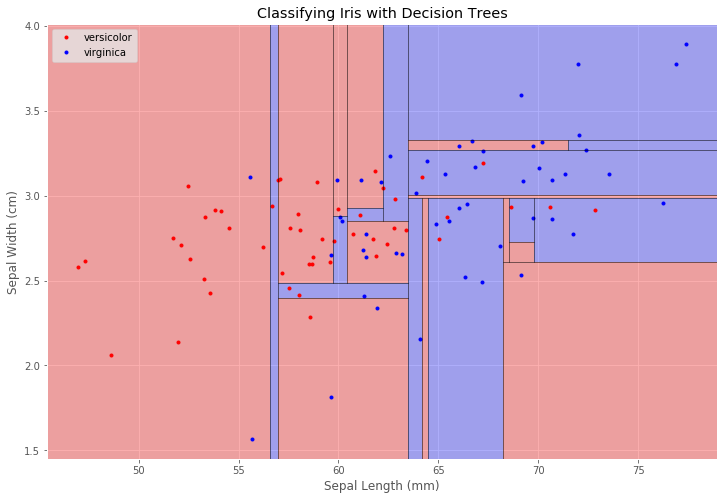

In [123]:
X, y = gen_similar_samples(X, y, 1)[0]
fig, ax = plt.subplots(figsize=(12,8))
plot_classification_tree(ax, X, y, model, fit = False)

#### What if we don't let it split so many times?

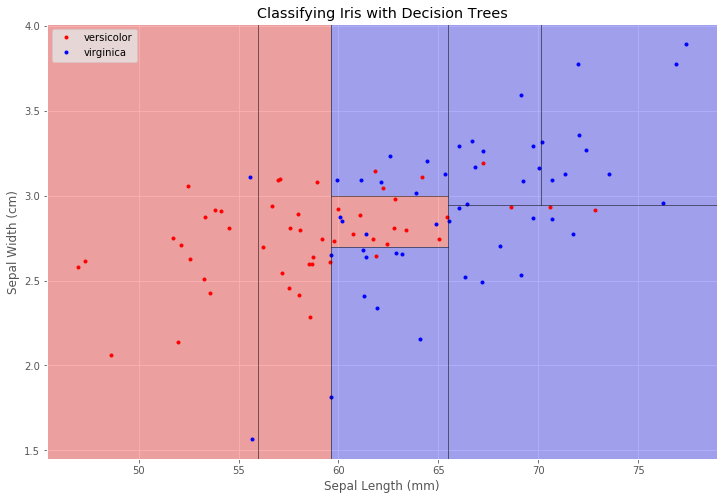

In [124]:
model = tree.DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 10)
fig, ax = plt.subplots(figsize=(12,8))
plot_classification_tree(ax, X, y, model)

## Picking the Best Tree

* Cross validate!
    * Train trees with different parameters, see which performs best on validation set
    * No different than any other model

## Pruning

We call the idea of modifying a decision tree to improve its performance **pruning**.

There are two approaches: **pre-pruning** (limiting the tree as we build it) and **post-pruning** (sometimes just called "pruning"; chopping back the tree after it is built.

### Pre

Prune as we build the tree, control hyper-parameters

Class discussion: what can we control?

In [125]:
help(tree.DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree.tree:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_depth : int or None, optional (default=None)
 |      The maximum depth of the tree. If None, then nodes are expanded until
 |      all leaves are pure or until all leaves contain less than
 |      min_samples_split samples.
 |  
 |  min_samples_split : int, float, optional (default=2)

In [126]:
with open('answers/preprune.txt') as f:
    hidden_answer(f)

### Post

Prune after we build the complete tree

* Merge leaves if doing so decreases *test-set* error
* If not leaves, consider each branch first (recursively)

#### Pseudocode
```
function Prune:
    if either left or right is not a leaf:
        call Prune on those that aren't
    if both left and right are (now) leaf nodes:
        calculate error associated with merging two leaf nodes
        calculate error associated without merging two leaf nodes
        if merging results in lower error:
            merge the leaf nodes
```

## Pros and Cons of Decision Trees

Class discussion: what do you think?

In [127]:
# load answers after class discussion
with open('answers/pc_dt.txt') as f:
    hidden_answer(f)

## The Decision Tree Algorithms

There are some famous variants of the decision tree algorithm:

### ID3

Short for Iterative Dichotomiser 3, the original Decision Tree algorithm developed by Ross Quinlan (who's responsible for a lot of proprietary decision tree algorithms) in the 1980's.

* designed for only categorial features
* splits categorical features completely
* uses entropy and information gain to pick the best split

### CART

Short for Classification and Regression Tree was invented about the same time as ID3 by Breiman, Friedman, Olshen and Stone. The CART algorithm has the following properties:

* handles both categorial and continuous data
* always uses binary splits
* uses gini impurity to pick the best split

Algorithms will be called CART even if they don't follow all of the specifications of the original algorithm.

### C4.5

This is Quinlan's first improvement on the ID3 algorithm. The main improvements are:

* handles continuous data
* implements pruning to reduce overfitting

### C5.0

This is supposedly better, but it's proprietary so we don't have access to the specifics of the improvements.